**Importing the NHIS data into a pandas dataframe**

In [2]:
# The data was downloaded from IPUMS and then formatted into a STATA data file
# Importing necessary libraries for the entire project

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# The rdd library allows for regression discontinuity analysis
from rdd import rdd

# Defining the filepath that contains the NHIS data, reading it in, and putting into a pandas dataframe

dtafile = r'C:\Users\devin\Documents\School\ECON6060FinalProject\NHIS2000.dta'

df = pd.read_stata(dtafile)

# Outputting a sample of the dataframe to make sure it loaded in correctly

print(df.tail())

# Putting the data into a SQLite database

con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')

df.to_sql("data", con, if_exists="replace")

con.close()

        year  serial  strata  psu         nhishid  hhweight     region  \
100613  2000   43301    5126    2  00002000072367      2491  Northeast   
100614  2000   43301    5126    2  00002000072367      2491  Northeast   
100615  2000   43301    5126    2  00002000072367      2491  Northeast   
100616  2000   43301    5126    2  00002000072367      2491  Northeast   
100617  2000   43301    5126    2  00002000072367      2491  Northeast   

        pernum           nhispid     hhx  ... mod10fwk vig10dmin  vig10fwk  \
100613       1  0020000723670101  072367  ...        0         0         0   
100614       2  0020000723670102  072367  ...        0         0         0   
100615       3  0020000723670103  072367  ...        0         0         0   
100616       4  0020000723670104  072367  ...        0         0         0   
100617       5  0020000723670105  072367  ...        0         0         0   

        strongfwk  bfhcan  bmhcan  fbnum fbnhcan fsnum  fsnhcan  
100613          0   

**Cleaning the data and creating necessary variables**

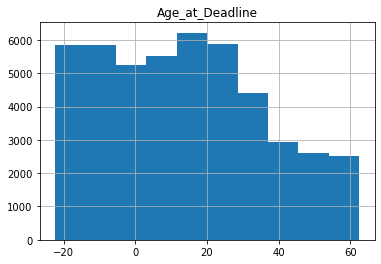

In [5]:
# Querying the database and limiting the sample to just women who have a birth
# year that isn't missing

con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
restricted = pd.read_sql_query("SELECT * FROM data WHERE sex = 'Female' AND birthyr < 2001", con)

# Creating dummy variables for region of residence at time of survey
restricted['Northeast'] = np.where(restricted['region'] == 'Northeast', 1, 0)

restricted['Midwest'] = np.where(restricted['region'] == 'North Central/Midwest', 1, 0)

restricted['South'] = np.where(restricted['region'] == 'South', 1, 0)

restricted['West'] = np.where(restricted['region'] == 'West', 1, 0)

# Creating the age variable which will be used as the running variable for the regression discontinuity analysis
# It is calculated to be the age of the individual in July of 1978

restricted.loc[restricted['birthmo'] == 'January', 'birthmo_num'] = 1
restricted.loc[restricted['birthmo'] == 'February', 'birthmo_num'] = 2
restricted.loc[restricted['birthmo'] == 'March', 'birthmo_num'] = 3
restricted.loc[restricted['birthmo'] == 'April', 'birthmo_num'] = 4
restricted.loc[restricted['birthmo'] == 'May', 'birthmo_num'] = 5
restricted.loc[restricted['birthmo'] == 'June', 'birthmo_num'] = 6
restricted.loc[restricted['birthmo'] == 'July', 'birthmo_num'] = 7
restricted.loc[restricted['birthmo'] == 'August', 'birthmo_num'] = 8
restricted.loc[restricted['birthmo'] == 'September', 'birthmo_num'] = 9
restricted.loc[restricted['birthmo'] == 'October', 'birthmo_num'] = 10
restricted.loc[restricted['birthmo'] == 'November', 'birthmo_num'] = 11
restricted.loc[restricted['birthmo'] == 'December', 'birthmo_num'] = 12

restricted['Age_at_Deadline'] = (1978 + (7/12)) - (restricted['birthyr'] + (restricted['birthmo_num'] / 12))

# Restricting the sample to only those with a birth month
    
restricted = restricted[restricted.birthmo != 'Unknown-refused']
restricted = restricted[restricted.birthmo != 'Unknown-not ascertained']
restricted = restricted[restricted.birthmo != "Unknown-don't know"]

hist = restricted.hist('Age_at_Deadline')

# Creating dummy variables for race and ethnicity

restricted['Hispanic'] = np.where(restricted['hispyn'] == 'Yes, of Hispanic ethnicity', 1, 0)

restricted['White'] = np.where(((restricted['racenew'] == 'White') & (restricted['Hispanic'] == 0)), 1, 0)

restricted['Black'] = np.where(((restricted['racenew'] == 'Black/African-American') & (restricted['Hispanic'] == 0)), 1, 0)

restricted['Other'] = np.where(((restricted['Hispanic'] == 0) & (restricted['White'] == 0) & (restricted['Black'] == 0)), 1, 0)

# Creating a dummy variable for if they were born in the US or not

restricted['US_born_dummy'] = np.where(((restricted['usborn'] == 'Yes, born in the U.S.') \
                                        | (restricted['usborn'] == 'No, born in U.S. territory')), 1 , 0)

# Creating a dummy variable and a continuous variable for height

restricted['Exceptional_Height'] = np.where(restricted['height'] == \
                                            'Exceptionally short or tall (2019-forward: or sex is unknown)', 1, 0)

restricted.loc[restricted['height'] == '59', 'Height_cont'] = 59
restricted.loc[restricted['height'] == '60', 'Height_cont'] = 60
restricted.loc[restricted['height'] == '61', 'Height_cont'] = 61
restricted.loc[restricted['height'] == '62', 'Height_cont'] = 62
restricted.loc[restricted['height'] == '63', 'Height_cont'] = 63
restricted.loc[restricted['height'] == '64', 'Height_cont'] = 64
restricted.loc[restricted['height'] == '65', 'Height_cont'] = 65
restricted.loc[restricted['height'] == '66', 'Height_cont'] = 66
restricted.loc[restricted['height'] == '67', 'Height_cont'] = 67
restricted.loc[restricted['height'] == '68', 'Height_cont'] = 68
restricted.loc[restricted['height'] == '69', 'Height_cont'] = 69
restricted.loc[restricted['height'] == '70', 'Height_cont'] = 70

# Creating the lifestyle variables
    
    # Drinking
    
restricted['Drinker'] = np.where(restricted['alcstat1'] == 'Current drinker (+1 drinks past year)', 1, 0)

    # Smoking
    
restricted['Smoker'] = np.where(((restricted['smokestatus2'] == 'Current every day smoker') | \
                                 (restricted['smokestatus2'] == 'Current some day smoker')), 1, 0)

    # Exercise
    
        # Values of 997, 998, and 999 indicated unknown values, so these observations are dropped
    
restricted = restricted[restricted.mod10dmin < 997]

restricted = restricted[restricted.vig10dmin < 997]
    
restricted['moderate_exercise'] = restricted['mod10dmin'] * restricted['mod10fwk']

restricted['vigorous_exercise'] = restricted['vig10dmin'] * restricted['vig10fwk']

        # Values of 94 (less than once per week), 95 (never), and 96 (unable to do this activity) are treated as zeroes
        # I'm creating both a dummy variable (which takes a value of 1 if the respondent does any strength-increasing
        # exercises, and 0 if not) and a variable which contains the number of times the respondent does
        # strength-increasing exercises per week

restricted['strong_dummy'] = np.where(((restricted['strongfwk'] < 94) & (restricted['strongfwk'] > 0)), 1, 0)

restricted['strong_freq'] = restricted['strongfwk']
restricted.loc[restricted['strong_freq'] > 93, 'strong_freq'] = 0

# Creating dummy variables for family members' cancer history. Unknowns are treated as a "no" or 0

restricted['father_cancer'] = np.where(restricted['bfhcan'] == 2, 1, 0)

restricted['mother_cancer'] = np.where(restricted['bmhcan'] == 2, 1, 0)

restricted['number_of_brothers'] = restricted['fbnum']
restricted.loc[restricted['number_of_brothers'] > 95, 'number_of_brothers'] = 0

restricted['number_of_brothers_cancer'] = restricted['fbnhcan']
restricted.loc[restricted['number_of_brothers_cancer'] > 95, 'number_of_brothers_cancer'] = 0

restricted['number_of_sisters'] = restricted['fsnum']
restricted.loc[restricted['number_of_sisters'] > 95, 'number_of_sisters'] = 0

restricted['number_of_sisters_cancer'] = restricted['fsnhcan']
restricted.loc[restricted['number_of_sisters_cancer'] > 95, 'number_of_sisters_cancer'] = 0